## Dihedral Analysis + Classification

We want to address what structural motifs are present in the terphenyl oligamer as it is subjected to the temperature changes of REMD. We will rerun the torsion analysis we ran on the vanilla MD simulations to confirm that the distributions are similar (meaning that we effectively sampled these distributions on our first pass) and to classify monomer structures to see what are typical conformations.

The goal of this analysis is to be able to extract specific frames coresponding to specific "classified" structures.

We will attempt 3 types of clustering in this jupyter-notebook. First we will

In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [142]:
import utils
import os
import h_bonds
import matplotlib.pyplot as plt
import numpy as np
import pandas
from sklearn.cluster import KMeans

In [4]:
torsion_ids = ["A", "B", "CC", "D", "E", "F", "G"]

torsion_annotations = [[torsion_id + str(i) for i in range(1, 5)] for torsion_id in torsion_ids]

Here we output the atoms making up the torsion we want to look at. These torsions are extracted from an annotated .itp file which has speicifc atoms manually selected. There are torsions A-G (with C being represented as CC to not be confused with carbon naming). Here we show that can extract torsions at all temperatures.

In [5]:
itp_reader = utils.ReadItpFile("../OCT_dihes.itp")
selector = itp_reader.construct_dihe_selection(torsion_annotations[1])

In [6]:
remd_trajs = h_bonds.REMD_trajectories("/mnt/summit/simulations/octamer_Rchiral/RHH/remd_sim/200K_to_350K", "npt", "whole.xtc","sim", "/mnt/summit/simulations/octamer_Rchiral/RHH/remd_sim/200K_to_350K/sim0/berendsen.gro", np = 4)

ReplicaReplicaReplica   603


Replica 9
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.whole.xtcnpt.part0004.whole.xtc

npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
Replica 1
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
Replica 10
Replica 7
Replica 4
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
ReplicaReplicaReplicaReplica    81152



npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
npt.whole.xtc
npt.part0002.whole.xtc
npt.part0003.whole.xtc
npt.part0004.whole.xtc
npt.whole.xtc
npt.part0002.whole.xtc
npt.part000

In [7]:
dihes = utils.get_dihedrals(selector, remd_trajs.trajs[0])

In [8]:
torsions_temps = []
for i_rep in range(remd_trajs.n_replicas):
    dihes_t = utils.get_dihedrals(selector, remd_trajs.trajs[i_rep])
    torsions_temps.append(dihes_t)

## All 1D Torsion Distributions

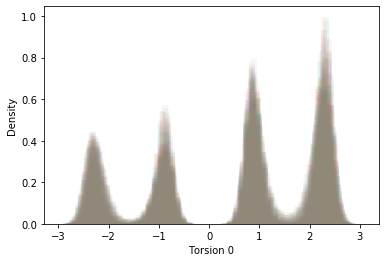

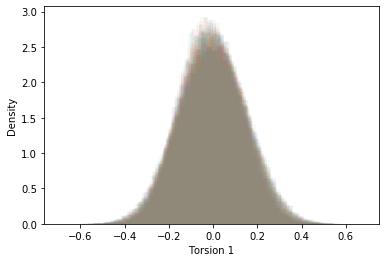

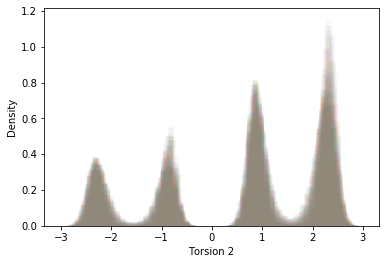

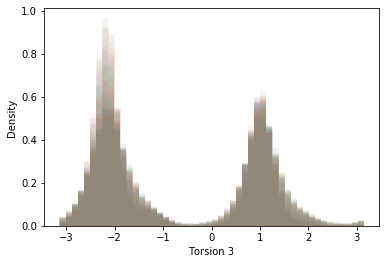

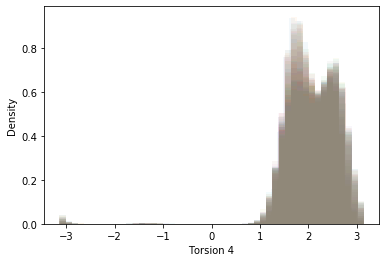

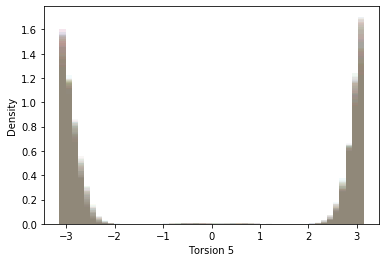

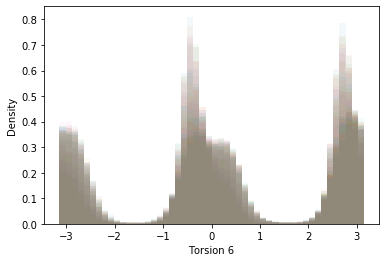

In [34]:
torsion_matrix = []
for i_torsions in range(len(torsion_annotations)):
    itp_reader = utils.ReadItpFile("../OCT_dihes.itp")
    selector = itp_reader.construct_dihe_selection(torsion_annotations[i_torsions])
    dihes = utils.get_dihedrals(selector, remd_trajs.trajs[0])
    torsions_temps = []
    for i_rep in range(remd_trajs.n_replicas):
        dihes_t = utils.get_dihedrals(selector, remd_trajs.trajs[i_rep])
        torsions_temps.append(dihes_t)
    plt.figure()
    for torsions in torsions_temps:
        hist = plt.hist(torsions, alpha = 0.05, bins=50, density=True)
    plt.xlabel("Torsion " + str(i_torsions))
    plt.ylabel("Density") 

## Monomer Classification

We can now extract the torsions for each temperature

In [65]:
classification_matrix = []
for i_torsions in range(len(torsion_annotations)):
    itp_reader = utils.ReadItpFile("../OCT_dihes.itp")
    selector = itp_reader.construct_dihe_selection(torsion_annotations[i_torsions])
    dihes = utils.get_dihedrals(selector, remd_trajs.trajs[0])
    torsions_temps = []
    for i_rep in range(remd_trajs.n_replicas):
        dihes_t = utils.get_dihedrals(selector, remd_trajs.trajs[i_rep])
        torsions_temps.append(dihes_t)
    all_torsions = np.array(torsions_temps)
    print(all_torsions.shape)
    total_torsions = all_torsions.shape[1]
    classification_matrix.append(all_torsions)

(40, 21648)
(40, 21648)
(40, 21648)
(40, 21648)
(40, 21648)
(40, 21648)
(40, 21648)


In [78]:
classification_matrix = np.array(classification_matrix)
print(classification_matrix.shape)
classification_matrix = classification_matrix.reshape(40, 7 * 6, int(classification_matrix.shape[2] / 6 ) )

(40, 42, 3608)


In [79]:
# Indicies represent:
# 1. Torsions
# 2. Residues
# 3. Temperature
# 4. frames
print(classification_matrix.shape)

(40, 42, 3608)


In [83]:
per_monomer_torsions = classification_matrix.reshape(classification_matrix.shape[0], -1)
print(per_monomer_torsions.shape)

# Convert to x and y components of torsions to remove periodic variables
per_monomer_torsions_comp = []
for i in range(per_monomer_torsions.shape[0]):
    per_monomer_torsions_comp.append(np.cos(per_monomer_torsions[i, :]))
    per_monomer_torsions_comp.append(np.sin(per_monomer_torsions[i, :]))
torsion_comps = np.array(per_monomer_torsions_comp).reshape(40, 84, 3608)
print(torsion_comps.shape)

(40, 151536)
(40, 84, 3608)


In [94]:
per_monomer_torsions = per_monomer_torsions.reshape(40, 42, 3608)
per_monomer_torsions.shape

(40, 42, 3608)

In [106]:
structure_class = []
n_residues = 6
n_torsions = 7
for j in range(per_monomer_torsions.shape[0]):
    per_temp_classes = []
    for i in range(per_monomer_torsions.shape[2]):
        id_str = ""
        torsions =  per_monomer_torsions[j, :, i]
        for k in range(n_residues):
            # Torsion 1
            # print("Index:", 0 + k*n_torsions)
            if  torsions[0 + k*n_torsions] >= -np.pi and torsions[0 + k*n_torsions] <= -np.pi/2:
                id_str += "0"
            elif torsions[0 + k*n_torsions] >= -np.pi/2 and torsions[0 + k*n_torsions] <= 0:
                id_str += "1"
            elif torsions[0 + k*n_torsions] >= 0 and torsions[0 + k*n_torsions] <= np.pi/2:
                id_str += "2"
            elif torsions[0 + k*n_torsions] >= np.pi/2 and torsions[0 + k*n_torsions] <= np.pi:
                id_str += "3"

            # Torsion 2
            # print("Index:", 2 + k*n_torsions)
            if  torsions[2+ k*n_torsions] >= -np.pi and torsions[2+ k*n_torsions] <= -np.pi/2:
                id_str += "0"
            elif torsions[2+ k*n_torsions] >= -np.pi/2 and torsions[2+ k*n_torsions] <= 0:
                id_str += "1"
            elif torsions[2+ k*n_torsions] >= 0 and torsions[2+ k*n_torsions] <= np.pi/2:
                id_str += "2"
            elif torsions[2+ k*n_torsions] >= np.pi/2 and torsions[2+ k*n_torsions] <= np.pi:
                id_str += "3"

            # Torsion 3
            # print("Index:", 3 + k*n_torsions)
            if  torsions[3+ k*n_torsions] >= - np.pi and torsions[3+ k*n_torsions] <= 0:
                id_str += "0"
            elif  torsions[3+ k*n_torsions] >= 0 and torsions[3+ k*n_torsions] <= np.pi:
                id_str += "1"

            # Torsion 4
            # print("Index:", 6 + k*n_torsions)
            if np.abs(torsions[6+ k*n_torsions]) <= np.pi/2:
                id_str += "0"
            elif np.abs(torsions[6+ k*n_torsions]) >= np.pi/2:
                id_str += "1"

        # Add to list
        per_temp_classes.append(id_str)
    structure_class.append(per_temp_classes)
structure_class = np.array(structure_class)

In [107]:
structure_class.shape

(40, 3608)

In [108]:
pandas.DataFrame(structure_class)

,0,1,2,3,4,5,6,7,8,9,...,3598,3599,3600,3601,3602,3603,3604,3605,3606,3607
0,211132100300211133101301,201022111201201032111300,231012002110321122102111,231013003110331112011010,121031113211030130112210,130031112211130021113211,211022100311311133101300,201132111200201032110301,221013002110321122002211,231003013110231112012110,...,130021103010130131113210,030030103311130131112211,321033110300311123111300,311123111301001033101301,231102002211221112003010,321013002111311113003110,130021103200121020112211,030030103311030010113310,321032110300311122101200,311122111201001032110200
1,211023111200301032100200,201033111200301122110300,231012002110131132002110,221013012110221112002010,030020103310030130103311,030030113311130120102310,211023112300201022110200,201033011200301122100300,231012002110321112013111,321012012111021012002010,...,120121111311130031100211,030020002210120121103311,201022110200221033110100,201132101301201133100301,231013003100321102113011,331113002011321103012110,110021113311030031102211,120020103311000120102311,201033110311211033110300,311032101201201032101301
2,201033101300311033110301,211002100210301133100200,231003002001231103002111,231001013010331013013101,120030113211120131100310,030020113211130111102211,211033111200201003111301,211002110300101122110200,231003003010331122013110,221001003011231002013111,...,030123103310120130113210,020131112311130020112111,300133111100311113101000,211032111200301132010201,321012012010301013012011,331003011311220012002011,031031113311020121113211,130131112300020031113011,211122000100201123100000,001032111210201032010211
3,301023001201211123100300,201132111201211103000301,321002012010231112013111,321013010110301023013010,130120100311110031102310,121101112211130131113211,311133100201331123100200,211023110301301122011201,331102012010321103003011,331013002210221112003010,...,100131112211130031103210,120020113311230021102311,221032100001311123100300,001000111200201131110310,321012003111231013003110,201110012011321003002010,000031102201020131112310,120132113211131030103211,221013010201201022101201,001123101310201133111301
4,301122101301211122111200,201023110201231132101200,321112010011221103012010,331102012010321013003100,130031102210120121103311,120020002311100130103311,311132100301211022110201,311132100301211122110200,221002013011321003012110,231102012101231013013111,...,120130102210130030113210,230111103011130100103211,211032111300211123101201,301122101100201133111301,321103002011231012002010,120003012311321012011010,120020112311030020112311,130123103110100030113110,311032101201211122110201,201022001301211022110301
5,211123110201301121101110,201123110301201121002100,331113013010121002002100,331113002101321101101100,120030112311010131101100,130031112311120021102200,301032111200301132102200,201023110201201121001100,331113013110121012002100,331103002101221102001200,...,130030113211030022002110,030030102310130022002100,301122100301301032002210,300133011300221122101210,221002003010231002001210,021003010011231101002100,030020103311030021002210,030031112301130021001100,301132111301301012001100,301132102000231122102100
6,110012102100111012102200,211011001210110011002100,111011101110220011101210,220021002110110022001210,111022001200221012101110,121012001200211012101210,220011101110211012001200,211022001200121012102110,221012102210221022001210,220012002110111021001110,...,110011101110110021102200,110012102100121021002200,211011002200121012002200,211012001100111022102100,220012002100211011102100,121011101100110012002110,110011102200220021002200,111012001100211011102210,221011001200111012101100,210012002210121021002200
7,121021001100211022101100,211011001210110021101110,110011102100210022001210,121012101200121012102100,210022101110111011002110,120012101200220012101200,220012001200221012102210,111021001210120022002110,221011002110211012002210,210012002110210022002200,...,220021001210221022101200,211011102200110021002100,211012102110121012001210,111022101110111011101110,110021102200210011002200,12

In [136]:
test = structure_class[4, :]
test

array(['301122101301211122111200', '201023110201231132101200',
       '321112010011221103012010', ..., '130123103110100030113110',
       '311032101201211122110201', '201022001301211022110301'],
      dtype='<U24')

In [137]:
# Go from 3608 vector of configrations to a 3608x3608 matrix of distances
dist_matrix = np.zeros([test.shape[0],test.shape[0]])
for i in range(test.shape[0]):
    for j in range(test.shape[0]):
        dist_matrix[i, j] = sum([int(test[i][k] != test[j][k]) for k in range(len(test[0]))])
print(dist_matrix)

[[ 0.  9. 14. ... 17.  6.  7.]
 [ 9.  0. 16. ... 18. 11. 12.]
 [14. 16.  0. ... 19. 16. 17.]
 ...
 [17. 18. 19. ...  0. 20. 19.]
 [ 6. 11. 16. ... 20.  0.  7.]
 [ 7. 12. 17. ... 19.  7.  0.]]


In [138]:
k_means = KMeans(n_clusters=3)
k_means.fit(dist_matrix)

KMeans(n_clusters=3)

In [139]:
k_means.labels_

array([1, 1, 2, ..., 0, 1, 1], dtype=int32)

For n_clusters = 2 The average silhouette_score is : 0.37354689089642873
For n_clusters = 3 The average silhouette_score is : 0.5106296117427321
For n_clusters = 4 The average silhouette_score is : 0.3634455243455187
For n_clusters = 5 The average silhouette_score is : 0.21118701609868706
For n_clusters = 6 The average silhouette_score is : 0.06514121928962993
For n_clusters = 7 The average silhouette_score is : 0.06557899324523385
For n_clusters = 8 The average silhouette_score is : 0.062811399502524
For n_clusters = 9 The average silhouette_score is : 0.05950786031724135


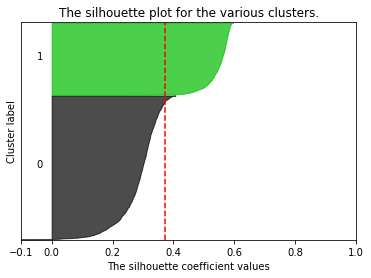

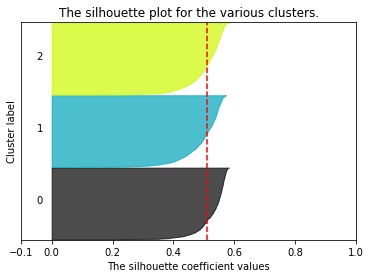

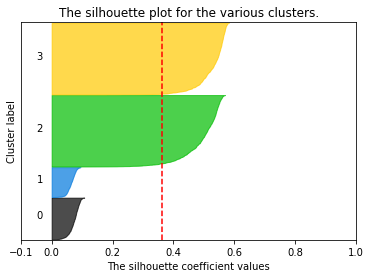

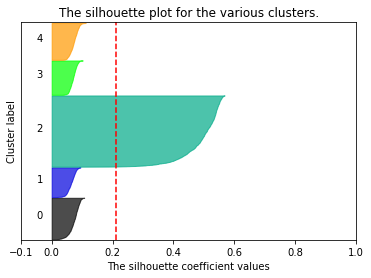

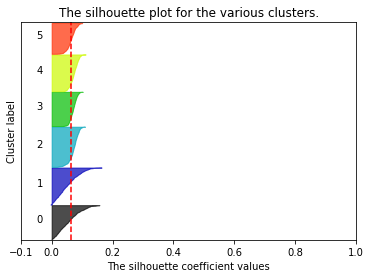

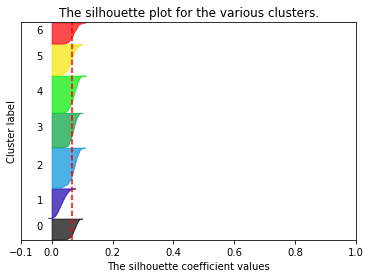

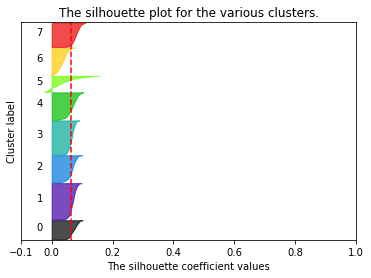

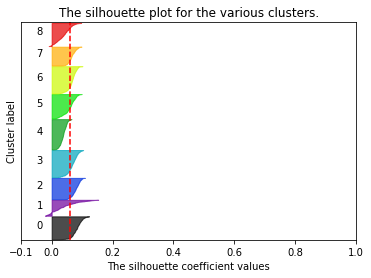

In [140]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = np.arange(2, 10, 1)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1= plt.subplots(1, 1)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(dist_matrix) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(dist_matrix)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dist_matrix, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dist_matrix, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # Labeling the clusters
    centers = clusterer.cluster_centers_

plt.show()

In [ ]:
if not os.path.isdir("binary_classification"):
    os.mkdir("binary_classification")
for i_temp in range(structure_class.shape[0]):
    test = structure_class[i_temp, :]
    # Go from 3608 vector of configrations to a 3608x3608 matrix of distances
    dist_matrix = np.zeros([test.shape[0],test.shape[0]])
    for i in range(test.shape[0]):
        for j in range(test.shape[0]):
            dist_matrix[i, j] = sum([int(test[i][k] != test[j][k]) for k in range(len(test[0]))])
    print(dist_matrix)
    k_means = KMeans(n_clusters=3)
    k_means.fit(dist_matrix)
    
    if not os.path.isdir(os.path.join("binary_classification", str(i_temp))):
        os.mkdir(os.path.join("binary_classification", str(i_temp)))
    for i_cluster in np.unique(k_means.labels_):
        print("Cluster index", i_cluster)
        cluster_index = np.where(k_means.labels_ == i_cluster)
        print(test[cluster_index])
        cluster = remd_trajs.trajs[i_temp][cluster_index]
        print(os.path.join("binary_classification", str(i_temp), "test_" + str(i_cluster) + ".pdb"))
        cluster.save(os.path.join("binary_classification", str(i_temp), "test_" + str(i_cluster) + ".pdb"))

## Clustering based on angle components

In [ ]:
from sklearn.cluster import MeanShift, estimate_bandwidth

In [ ]:
per_monomer_torsions_comp.shape

In [ ]:
bandwidth = 1.53
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=-1)
ms.fit(per_monomer_torsions_comp.T)
labels = ms.labels_
np.unique(labels)

In [ ]:
label_per_residue_temp_frame = labels.reshape(*classification_matrix.shape[1:])
label_per_residue_temp_frame.shape

In [ ]:
unique, counts = np.unique(labels,return_counts=True)

for u, c in zip(unique, counts):
    print("Cluster", u, ":", c)

In [ ]:
cluster_torsions = [np.arctan2(ms.cluster_centers_[:, 2*i + 1], ms.cluster_centers_[:, 2*i]) for i in range(7)]
cluster_torsions = np.array(cluster_torsions)
cluster_torsions.shape

In [ ]:
import matplotlib
cm = matplotlib.cm.cmap_d["Set1"]

cluster_id = 0
colors = cm(np.linspace(0,1,7))
for i in range(7):
    plt.figure(dpi=300)
    hist = plt.hist(np.arctan2(per_monomer_torsions_comp[2*i + 1,:], per_monomer_torsions_comp[2*i,:]), bins=80, density=True, color=colors[i])
    print(colors[i])
    plt.xlabel("Torsion " + str(i))
    plt.ylabel("Density")
    plt.savefig("terphenyl_remd_torsion_" + str(i) + ".png")
    colors = cm(np.linspace(0,1,cluster_torsions.shape[1]))
    for j in range(cluster_torsions.shape[1]):
        plt.vlines(cluster_torsions[i,j], ymin=0, ymax=np.max(hist[0]), color = colors[j], linestyles = "dotted", linewidths=2)

In [ ]:
# Extract structures of clusters

## RMSD Clustering

